STEP 1: Loading the final processed dataset (.csv)...
Parsing with semicolon resulted in too few columns, trying with comma...
Final dataset loaded successfully!

--- Starting new Task G3 analysis ---

--- STEP 3: Generating failure mileage distribution plot ---


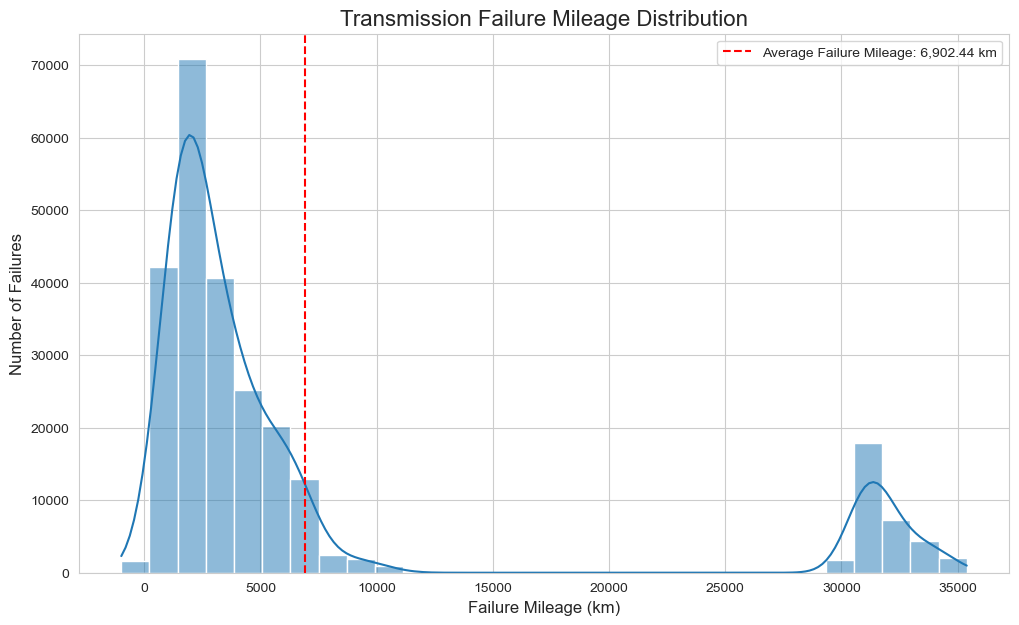


              Task G3 Final Result (New)
The average failure mileage for defective transmissions is: 6,902.44 km


In [11]:
# -*- coding: utf-8 -*-
# Purpose: Calculate the average failure mileage of transmissions and generate a chart on the final processed dataset.
# Version: 5.0 - Includes visualization

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# Path to the data folder
BASE_DIR = Path("./case/data")
# Filename of the final dataset
FINAL_DATASET_FILE = BASE_DIR / "Final_dataset_group_23.csv"

def read_final_csv(file_path: Path) -> pd.DataFrame:
    """
    A robust function to read the final CSV dataset, trying both semicolon and comma as separators.
    """
    try:
        # First, try to read with a semicolon separator
        df = pd.read_csv(file_path, sep=";", quotechar='"', dtype=str, encoding="utf-8", engine="python")
        # Check if multiple columns were parsed successfully. If not, the separator is likely wrong, so try with a comma.
        if df.shape[1] <= 1:
            print("Parsing with semicolon resulted in too few columns, trying with comma...")
            df = pd.read_csv(file_path, sep=",", quotechar='"', dtype=str, encoding="utf-8", engine="python")
        return df
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        raise

# -----------------------------
# STEP 1: Load the final dataset
# -----------------------------
print("STEP 1: Loading the final processed dataset (.csv)...")

if not FINAL_DATASET_FILE.exists():
    raise FileNotFoundError(f"Final dataset file not found: '{FINAL_DATASET_FILE}'")

df = read_final_csv(FINAL_DATASET_FILE)
print("Final dataset loaded successfully!")


# -----------------------------
# STEP 2: Execute new Task G3 analysis (calculate average failure mileage)
# -----------------------------
print("\n--- Starting new Task G3 analysis ---")

# --- Define column names for analysis ---
# You need to confirm these column names are correct in your file
defective_flag_col = 'transmission_defective_flag' # Flag column for whether the transmission is defective
mileage_col = 'transmission_defective_mileage'    # Mileage column for when the transmission failed

# Check if necessary columns exist
required_columns = {defective_flag_col, mileage_col}
if not required_columns.issubset(df.columns):
    print(f"Error: Necessary columns are missing from the dataset. Required: '{defective_flag_col}' and '{mileage_col}'.")
    print(f"Actual columns in the dataset are: {df.columns.tolist()}")
    avg_mileage = "Cannot calculate (missing required columns)"
    defective_transmissions = pd.DataFrame() # Create an empty DataFrame so subsequent code doesn't error out
else:
    # 1. Filter for all rows recorded as failures (flag is '1')
    defective_transmissions = df[df[defective_flag_col] == '1'].copy() # Use .copy() to avoid a warning
    
    if defective_transmissions.empty:
        print("No defective transmission records found in the data.")
        avg_mileage = 0
    else:
        # 2. Convert mileage column to a numeric type for calculation
        defective_transmissions[mileage_col] = pd.to_numeric(defective_transmissions[mileage_col], errors='coerce')
        
        # 3. Calculate the mean of the mileage column
        avg_mileage = defective_transmissions[mileage_col].mean()

# -----------------------------
# STEP 3: Generate image (new)
# -----------------------------
# Only plot if the average mileage was successfully calculated
if isinstance(avg_mileage, (int, float)) and not defective_transmissions.empty:
    print("\n--- STEP 3: Generating failure mileage distribution plot ---")
    
    # Set plot style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    
    # Plot histogram
    sns.histplot(data=defective_transmissions, x=mileage_col, bins=30, kde=True)
    
    # Mark the average value's position on the plot
    plt.axvline(avg_mileage, color='red', linestyle='--', label=f'Average Failure Mileage: {avg_mileage:,.2f} km')
    
    # Add title and labels
    plt.title('Transmission Failure Mileage Distribution', fontsize=16)
    plt.xlabel('Failure Mileage (km)', fontsize=12)
    plt.ylabel('Number of Failures', fontsize=12)
    plt.legend() # Display the legend (which includes the average value line)
    
    # Display the plot
    plt.show()


# -----------------------------
# STEP 4: Print the final result
# -----------------------------
print("\n" + "="*50)
print("              Task G3 Final Result (New)")
print("="*50)
if isinstance(avg_mileage, (int, float)):
    print(f"The average failure mileage for defective transmissions is: {avg_mileage:,.2f} km")
else:
    print(f"Could not calculate average failure mileage: {avg_mileage}")
print("="*50)

